# Fall 2025 - Assignment 1

Electronic submission on ZoneCours no later than **October 17 at 11:55 PM** of:

* This Jupyter notebook (.ipynb) as the report, after adding your answers.
* All .py files necessary to run the notebook

The report must:

* be in .ipynb format (points will be deducted for any other format).
* include the student ID number of all team members in the first cell (i.e., replace these instructions).
* answer the questions and discuss the results using tables, figures, and Markdown cells.

Grading rubric:

* **40%** Accuracy of results
* **25%** Complete and concise discussions (Markdown cells)
* **20%** Conciseness of the notebook (.ipynb with minimal code) and clarity of figures
* **15%** Code clarity (.py)

# Context

We are going to consider the most liquid options traded on Apple on two particular business days of 2020: January 17 and March 20. The next couple of code cells were used to generate the dataset by connecting to OptionMetrics. With `GENERATE = False`, they simply load the dataset as saved to disk.

In [1]:
# The following import allow absolute imports scripts within the dorion_francois package
#import internal_script 
import datetime as dt
import os
import sys
import numpy as np
import pandas as pd
import pickle
import importlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

In [3]:
def filters(options):
    """These filters were applied to the data"""
    # Options before maturity
    options = options.loc[options.date < options.exdate].reset_index()

    # Positive open interest
    options = options[options['open_interest'] > 0] 

    # Abs(delta) between 0.01 and 0.99
    options = options[(options['delta'].abs() >= 0.01) & (options['delta'].abs() <= 0.99)] 

    # Implied vol between 0.03 and 2
    options = options[(options['impl_volatility'] >= 0.03) & (options['impl_volatility'] <= 2)] 

    # Bid price is greater than 0.1 and less than ask price
    options = options[(options['best_offer'] > options['best_bid']) & (options['best_bid'] > 0.1)] 
    
    return options

GENERATE = False
if GENERATE:
    import dorion_francois.option_metrics as om    
    jan17 = om.get_option_data(101594, dt.date(2020,1,17))
    mar20 = om.get_option_data(101594, dt.date(2020,3,20))
    options = filters( pd.concat((jan17,mar20),axis=0) )
    with open('202510-assignment1.pkl','wb') as fh:
        # OptionMetrics 'strike_price' column is the strike x1000. We'll drop it to avoid confusion; use the 'strike' column
        pickle.dump(options.drop(columns=['strike_price']),fh)
else:
    with open('202510-assignment1.pkl','rb') as fh:
        options = pickle.load(fh)
options.describe()

options['date'] = pd.to_datetime(options['date'], format='%d-%m-%Y')
options['exdate'] = pd.to_datetime(options['exdate'], format='%d-%m-%Y')


# Question 1

Create a scatter plot with the risk-free rate (`100*options.risk_free`) against the time to maturity expressed in years (`options.YTM`). Discuss the figure. Given that the Black-Merton-Scholes economy assumes that the risk-free rate is constant, should one still account for the variation it illustrates if pricing options with the model? Why?

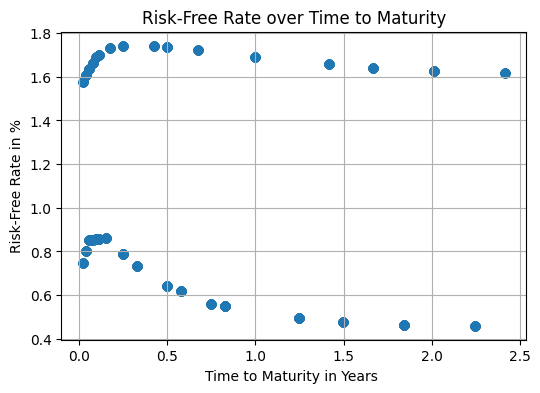

In [4]:
plt.figure(figsize=(6, 4))
plt.scatter(options["YTM"], 100 * options["risk_free"], alpha=0.7)
plt.title("Risk-Free Rate over Time to Maturity")
plt.xlabel("Time to Maturity in Years ")
plt.ylabel("Risk-Free Rate in %")
plt.grid(True)
plt.show()

If the Black-Merton-Scholes (BMS) assumptions held perfectly, the points would form a horizontal line, indicating a constant risk-free rate across maturities. However, in practice, the figure typically shows variation — often with a slight upward or downward trend — reflecting the term structure of interest rates (the yield curve).

In real-world applications, one should account for the variation if:
- The options have long maturities, and the term structure significantly affects discounting. Using the appropriate risk-free rate for each maturity (YTM-dependent rate) yields more realistic valuations.
- One is using market data calibrated to zero-coupon yields rather than a flat rate.

# Question 2
Similarly, scatter `options.stock - options.stock_exdiv`, where the former is the stock price and the latter accounts for the dividends **actually** paid over the life of the options.

Discuss the figure. Can we conclude that Apple changed its dividend policy between the two dates? Describe which variation of the Black-Merton-Scholes formula seen in class could be used to price the options on Apple if they were European options. Support your discussion with succinct mathematical expressions and/or derivations, in which you can focus on the calls without loss of generality.

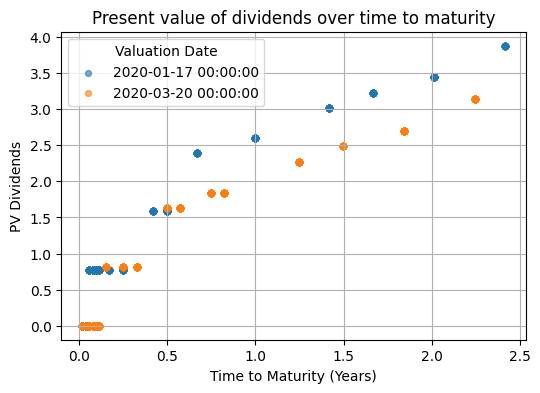

In [5]:
plt.figure(figsize=(6, 4))
for d, g in options.groupby(options["date"]):
    plt.scatter(g["YTM"], g["stock_price"]- g["stock_exdiv"], alpha=0.6, label=str(d), s=18)
plt.title("Present value of dividends over time to maturity")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("PV Dividends")
plt.grid(True)
plt.legend(title="Valuation Date")
plt.show()

**Discussion of the figure**

- The vertical axis $S - S_{\text{exdiv}}$ equals the **present value of the dividends actually paid** during the option’s life (from the valuation date until expiry).
- Points fall into **step-like levels** (roughly $0,\; \approx 0.8,\; \approx 1.6,\; \approx 2.4,\dots$ USD): each step indicates an additional **cash dividend** that will occur before expiration ($0,1,2,3,\ldots$ payments).
- Comparing the two valuation dates in the data (2020-01-17 vs 2020-03-20), the step pattern shifts because the set of ex-dividend dates that fall within each maturity window changes and because of discounting. This **does not imply a change in policy**.

**Conclusion on policy:** The plot is consistent with a **stable, regular cash dividend**. The differences between the two dates arise from **calendar overlap** (which expirations include how many dividends) and **discounting**, not a dividend policy change by Apple.



**Which BMS variation to use (European options)?**

Let $T$ be the maturity and $r$ the continuously-compounded risk-free rate. For **cash dividends paid at known dates** $t_i \le T$ with amounts $d_i$, the standard approach is the **discrete-dividend adjustment**:
1. Subtract the present value of dividends from the spot:

$$
D = \sum_{t_i \le T} d_i\,e^{-r t_i}, \qquad S_0^* = S_0 - D.
$$

2. Price with Black–Scholes **as if there were no dividends**, using $S^*$


# Question 3
Implement a function that inverts this variation of the BSM formula to obtain the BMS implied volatility for each of the options in the dataframe. Define moneyness as $M = K / \hat{S}_t$ and focus on out-of-the-money (OTM) options ($M \le 1$ puts, $M > 1$ calls). Create a dataframe `otm_options` containing only those options and add a column with the result of your IV calculation for each option therein.

In a 1x2 figure, scatter your results, with  on the x-axis, against a line plot for `implied_vol_bms`: In the left (right) panel, use options quoted on Jan 17 and expiring on Feb 14 (July 17), 2020, and options quoted on Mar 20 expiring on April 17 (Oct. 16), 2020. On each panel, you should thus have 2 lines with your results scattered atop them. Discuss this figure: how does the level and span (across moneyness) of the smiles vary, compare across maturities, etc. Given your discussion, can you suggest a better measure for moneyness? If you generate a new the previous figure using this alternate moneyness measure, how does it impact your analysis of the figure?

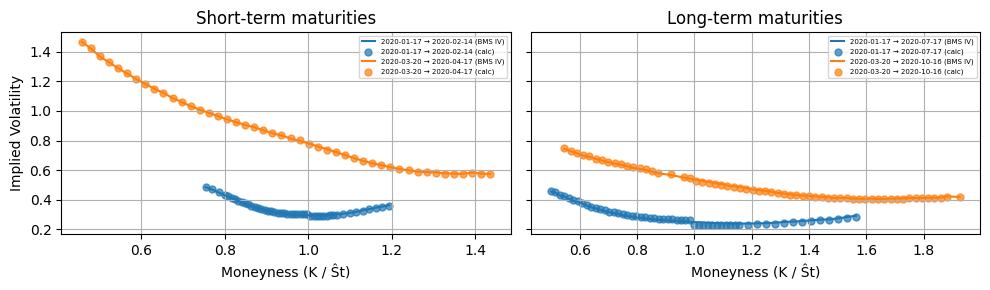

,symbol,date,exdate,is_call,M,implied_vol_bms,implied_vol_calc
69,AAPL 200124P290000,2020-01-17,2020-01-24,False,0.910017,0.344050,0.344969
71,AAPL 200124P292500,2020-01-17,2020-01-24,False,0.917862,0.330251,0.331208
73,AAPL 200124P295000,2020-01-17,2020-01-24,False,0.925707,0.311866,0.312856
75,AAPL 200124P297500,2020-01-17,2020-01-24,False,0.933552,0.296303,0.297340
77,AAPL 200124P300000,2020-01-17,2020-01-24,False,0.941397,0.279462,0.280550


In [6]:
# Define Black-Scholes call and put pricing functions (continuous yield q version)
def bsm_price(S, K, T, r, q, sigma, option_type="call"):
    if T <= 0 or sigma <= 0:
        return max(0.0, S - K) if option_type == "call" else max(0.0, K - S)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

# Implied volatility inversion
def implied_volatility(price, S, K, T, r, q=0, option_type="call"):
    try:
        objective = lambda sigma: bsm_price(S, K, T, r, q, sigma, option_type) - price
        return brentq(objective, 1e-6, 5.0, maxiter=1000)
    except ValueError:
        return np.nan

# Compute moneyness and focus on OTM options
options["M"] = options["strike"] / options["implied_forward_price"]
otm_options = options[((options["is_call"]) & (options["M"] > 1)) | 
                      ((~options["is_call"]) & (options["M"] <= 1))].copy()

# Compute implied volatility from bid/ask midprice (or option_price as fallback)
otm_options["mid_price"] = otm_options[["best_bid", "best_offer"]].mean(axis=1).fillna(otm_options["option_price"])
otm_options["implied_vol_calc"] = otm_options.apply(
    lambda row: implied_volatility(
        price=row["mid_price"],
        S=row["implied_forward_price"],
        K=row["strike"],
        T=row["YTM"],
        r=row["risk_free"],
        q=0,
        option_type="call" if row["is_call"] else "put"
    ),
    axis=1
)

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
left_pairs = [(pd.Timestamp("2020-01-17"), pd.Timestamp("2020-02-14")),
              (pd.Timestamp("2020-03-20"), pd.Timestamp("2020-04-17"))]
right_pairs = [(pd.Timestamp("2020-01-17"), pd.Timestamp("2020-07-17")),
               (pd.Timestamp("2020-03-20"), pd.Timestamp("2020-10-16"))]

def plot_smiles(ax, pairs, title):
    for d, e in pairs:
        subset = otm_options[(otm_options["date"] == d) & (otm_options["exdate"] == e)].sort_values("M")
        ax.plot(subset["M"], subset["implied_vol_bms"], label=f"{d.date()} → {e.date()} (BMS IV)")
        ax.scatter(subset["M"], subset["implied_vol_calc"], s=25, alpha=0.7, label=f"{d.date()} → {e.date()} (calc)")
    ax.set_title(title)
    ax.set_xlabel("Moneyness (K / Ŝt)")
    ax.grid(True)
    ax.legend(fontsize=5)

plot_smiles(axes[0], left_pairs, "Short-term maturities")
plot_smiles(axes[1], right_pairs, "Long-term maturities")
axes[0].set_ylabel("Implied Volatility")
plt.tight_layout()
plt.show()

otm_options[["symbol", "date", "exdate", "is_call", "M", "implied_vol_bms", "implied_vol_calc"]].head()


<u>Discussion of the Figure and Results</u>: The figure illustrates **volatility smiles** for Apple’s options across short- and long-term maturities. The reported BMS implied volatilities (`implied_vol_bms`, lines) and the recomputed implied volatilities from our inversion function (`implied_vol_calc`, scatter points) overlap closely, confirming the accuracy of the inversion.

<u>Observations</u>: For **short-term maturities**, the smiles are **steeper**: implied volatility rises sharply for deep out-of-the-money puts and calls. The **level** of volatility is higher on March 20 than on January 17, reflecting market stress during early 2020. The **span** of the smile (difference between high and low implied volatilities) is wider, indicating a stronger skew for near-term options.  
In contrast, **long-term maturities** show **flatter and lower** smiles, suggesting that volatility varies less with moneyness and that longer expirations smooth out temporary market fluctuations.

<u>A Better Measure of Moneyness</u>: 

The classical definition 

$$
M = \frac{K}{\hat{S}_t}
$$ 

ignores the time value of money and the forward level of the asset. A more robust, scale-invariant metric is the **log-forward moneyness**:

$$
m = \ln\!\left(\frac{K}{F_t}\right), \quad \text{where } F_t = S_t e^{(r - q)T}.
$$

Alternatively, the **delta** ($N(d_1)$ or $N(d_2)$) can serve as a practical proxy, aligning smiles across maturities since it captures the option’s sensitivity to the underlying.

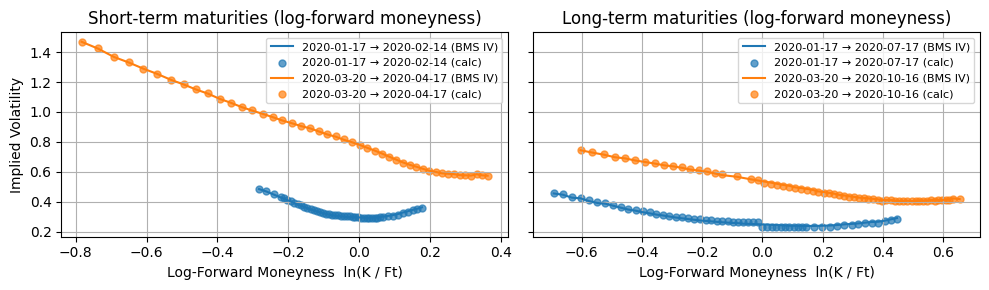

In [7]:
# Add log-forward moneyness and replot the implied volatility smiles using it
otm_options["log_forward_m"] = np.log(otm_options["strike"] / otm_options["implied_forward_price"])

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
def plot_smiles_logm(ax, pairs, title):
    for d, e in pairs:
        subset = otm_options[(otm_options["date"] == d) & (otm_options["exdate"] == e)].sort_values("log_forward_m")
        ax.plot(subset["log_forward_m"], subset["implied_vol_bms"], label=f"{d.date()} → {e.date()} (BMS IV)")
        ax.scatter(subset["log_forward_m"], subset["implied_vol_calc"], s=25, alpha=0.7, label=f"{d.date()} → {e.date()} (calc)")
    ax.set_title(title)
    ax.set_xlabel("Log-Forward Moneyness  ln(K / Ft)")
    ax.grid(True)
    ax.legend(fontsize=8)

plot_smiles_logm(axes[0], left_pairs, "Short-term maturities (log-forward moneyness)")
plot_smiles_logm(axes[1], right_pairs, "Long-term maturities (log-forward moneyness)")
axes[0].set_ylabel("Implied Volatility")
plt.tight_layout()
plt.show()

<u>Replotting Using Log-Forward Moneyness</u>: 

When the smiles are plotted against 

$$
m = \ln\!\left(\frac{K}{F_t}\right),
$$

they align more symmetrically around $m = 0$, the at-the-money forward point. This adjustment reduces distortions due to interest rates and maturities, making **cross-maturity comparisons clearer**. Short-term smiles remain steeper (indicating near-term skew), but the differences across maturities become easier to interpret, since “ATM” is now defined consistently.


# Question 4

Consider the same OTM options as in the previous question. We now want to scatter
\begin{equation}
    100 \left(\frac{ \text{'impl\_volatility'} }{ \text{'implied\_vol\_bms'} } - 1\right)
\end{equation}
against moneyness (the version you feel most comfortable with). The 'impl_volatility' column provides an implied volatility measure as computed by the data provider using a proprietary algorithm. How should the y-axis be interpreted? Are the magnitudes relatively large or small? Would we obtain the same result comparing CRR and BMS implied volatilities for the in-the-money (ITM) options?

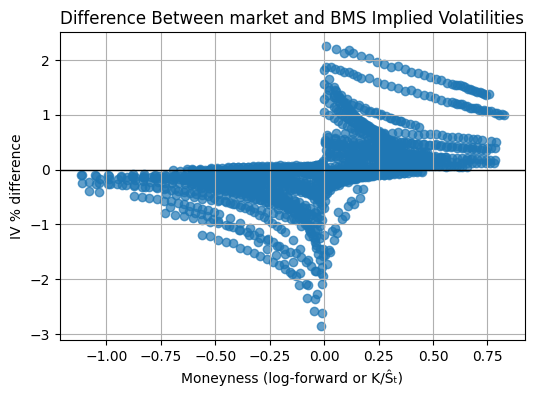

In [8]:
# Compute the relative difference in percentage
otm_options["vol_diff_pct"] = 100 * (otm_options["impl_volatility"] / otm_options["implied_vol_bms"] - 1)

moneyness_col = "log_forward_m" 

# Plot scatter of volatility difference vs. moneyness
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(otm_options[moneyness_col], otm_options["vol_diff_pct"], alpha=0.7)
ax.axhline(0, color='black', lw=1)
ax.set_title("Difference Between market and BMS Implied Volatilities")
ax.set_xlabel("Moneyness (log-forward or K/Ŝₜ)")
ax.set_ylabel("IV % difference")
ax.grid(True)
plt.show()


### Interpretation of the Figure

The y-axis shows the **percentage difference** between the provider’s implied volatility and the BMS-implied volatility
- **Positive values** → provider’s IV is higher than BMS.  
- **Negative values** → provider’s IV is lower.  
- Values near **0** mean both estimates agree closely.

The differences (roughly −3% to +2%) are **small**, indicating strong consistency between the proprietary and BMS volatilities for OTM options.  
For **ITM options**, differences would likely be **larger**, since models like **CRR** account for **early exercise** effects, unlike BMS.


# Question 5
Convert the present value of dividends corresponding to each option into an approximate convenience yield. Implement the CRR tree with diviended yield ($y$) and obtain your own CRR-implied volatility; use a number of time steps equal to 5 times the days to maturity ('DTM').  Compare it with the 'impl_volatility' provided in the dataframe. In particular, does this yield better approximations than the ones in 'implied_vol_bms'? Support your answer with some summary statistics and a figure.

In [13]:
#############################################################
## 1) Convert PV(dividends) and find convenience yield y ####
#############################################################

# Convert the present value of dividends corresponding to each option into an approximate convenience yield
# Using: F = (S - PVdiv) * e^{rT}  => PVdiv = S - F * e^{-rT}
# Then approximate continuous dividend yield y via: PVdiv = S * (1 - e^{-y T})  => y = -(1/T) ln(1 - PVdiv / S)
S = options["stock_price"].values
F_impl = options["implied_forward_price"].values
r = options["risk_free"].values
T = options["YTM"].values

PVdiv = S - F_impl * np.exp(-r * T)
ratio = PVdiv / S
y_conv = -np.log(1 - ratio) / T
options["conv_yield_from_pvdiv"] = y_conv

#############################################################
########## 2) CRR tree pricing with dividend yield ##########
#############################################################

def crr_price(S, K, r, y, sigma, T, N, is_call=True):
    if T <= 0 or N < 1 or sigma <= 0:
        # Immediate expiry: option worth intrinsic
        intrinsic = max(0.0, (S - K) if is_call else (K - S))
        return intrinsic
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    disc = np.exp(-r * dt)
    # risk-neutral probability with dividend yield y
    m = np.exp((r - y) * dt)
    p = (m - d) / (u - d)
    if not (0 < p < 1):
        p = min(max(p, 1e-9), 1 - 1e-9)
    # Underlying prices at maturity
    # S_N(k) = S * u^k * d^(N-k)
    # Payoffs at maturity
    prices = np.array([S * (u**k) * (d**(N - k)) for k in range(N + 1)])
    if is_call:
        vals = np.maximum(prices - K, 0.0)
    else:
        vals = np.maximum(K - prices, 0.0)
    # Backward induction
    for _ in range(N):
        vals = disc * (p * vals[1:] + (1 - p) * vals[:-1])
    return float(vals[0])

#############################################################
############ 3) CRR-implied vol via root finding ############
#############################################################

market_price = options["option_price"].values
K = options["strike"].values
is_call = options["is_call"].astype(bool).values
N_steps = (options["DTM"].astype(int)*5).values  

def iv_from_price_row(i):
    Si, Ki, ri, yi, Ti, Pi, Ni, iscall = S[i], K[i], r[i], y_conv[i], T[i], market_price[i], int(N_steps[i]), bool(is_call[i])
    # Bounds for sigma
    lo, hi = 1e-6, 5.0
    # Price at bounds
    try:
        f_lo = crr_price(Si, Ki, ri, yi, lo, Ti, Ni, iscall) - Pi
        f_hi = crr_price(Si, Ki, ri, yi, hi, Ti, Ni, iscall) - Pi
        # Ensure a sign change; if not, widen hi once
        if f_lo * f_hi > 0:
            hi2 = 7.0
            f_hi2 = crr_price(Si, Ki, ri, yi, hi2, Ti, Ni, iscall) - Pi
            if f_lo * f_hi2 > 0:
                return np.nan
            else:
                root = brentq(lambda x: crr_price(Si, Ki, ri, yi, x, Ti, Ni, iscall) - Pi, lo, hi2, maxiter=1000)
                return root
        root = brentq(lambda x: crr_price(Si, Ki, ri, yi, x, Ti, Ni, iscall) - Pi, lo, hi, maxiter=1000)
        return root
    except Exception:
        return np.nan

#############################################################
####################### 3) Compute IVs ######################
#############################################################
iv_crr = []
for i in range(len(options)):
    iv_crr.append(iv_from_price_row(i))
    print(round(i*100/len(options),1), "%")
options["iv_crr"] = iv_crr

0.0 %
0.0 %
0.1 %
0.1 %
0.1 %
0.2 %
0.2 %
0.2 %
0.3 %
0.3 %
0.3 %
0.4 %
0.4 %
0.4 %
0.5 %
0.5 %
0.5 %
0.6 %
0.6 %
0.6 %
0.7 %
0.7 %
0.7 %
0.8 %
0.8 %
0.8 %
0.9 %
0.9 %
0.9 %
1.0 %
1.0 %
1.0 %
1.1 %
1.1 %
1.1 %
1.2 %
1.2 %
1.2 %
1.2 %
1.3 %
1.3 %
1.3 %
1.4 %
1.4 %
1.4 %
1.5 %
1.5 %
1.5 %
1.6 %
1.6 %
1.6 %
1.7 %
1.7 %
1.7 %
1.8 %
1.8 %
1.8 %
1.9 %
1.9 %
1.9 %
2.0 %
2.0 %
2.0 %
2.1 %
2.1 %
2.1 %
2.2 %
2.2 %
2.2 %
2.3 %
2.3 %
2.3 %
2.4 %
2.4 %
2.4 %
2.5 %
2.5 %
2.5 %
2.6 %
2.6 %
2.6 %
2.7 %
2.7 %
2.7 %
2.8 %
2.8 %
2.8 %
2.9 %
2.9 %
2.9 %
3.0 %
3.0 %
3.0 %
3.1 %
3.1 %
3.1 %
3.2 %
3.2 %
3.2 %
3.3 %
3.3 %
3.3 %
3.4 %
3.4 %
3.4 %
3.5 %
3.5 %
3.5 %
3.6 %
3.6 %
3.6 %
3.7 %
3.7 %
3.7 %
3.7 %
3.8 %
3.8 %
3.8 %
3.9 %
3.9 %
3.9 %
4.0 %
4.0 %
4.0 %
4.1 %
4.1 %
4.1 %
4.2 %
4.2 %
4.2 %
4.3 %
4.3 %
4.3 %
4.4 %
4.4 %
4.4 %
4.5 %
4.5 %
4.5 %
4.6 %
4.6 %
4.6 %
4.7 %
4.7 %
4.7 %
4.8 %
4.8 %
4.8 %
4.9 %
4.9 %
4.9 %
5.0 %
5.0 %
5.0 %
5.1 %
5.1 %
5.1 %
5.2 %
5.2 %
5.2 %
5.3 %
5.3 %
5.3 %
5.4 %
5.4 %
5.4 %
5.5 

,count,mean,std,min,25%,50%,75%,max
abs_err_crr,3041.0,0.010740,0.049517,2.418000e-06,0.000848,0.002564,0.008204,1.791446
abs_err_bms,3039.0,0.009509,0.021883,4.744767e-07,0.000719,0.002576,0.007995,0.432859
err_crr,3041.0,0.004210,0.050493,-1.791446e+00,-0.000615,0.001063,0.005911,0.193056
err_bms,3039.0,0.005209,0.023284,-4.328589e-01,-0.000545,0.000870,0.005792,0.192554


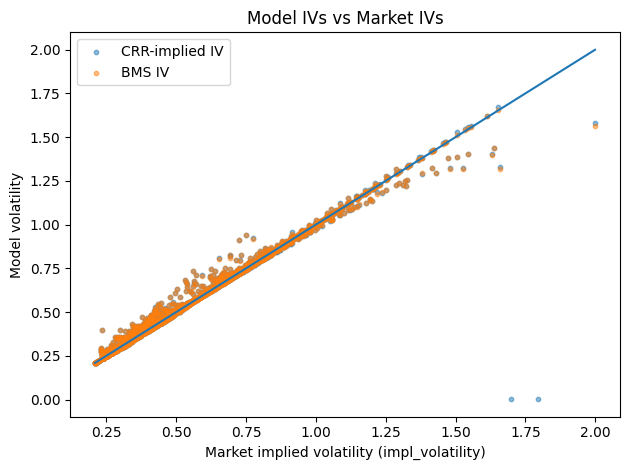

In [ ]:

#############################################################
###### 4) Compare  impl_volatility and implied_vol_bms ######
#############################################################

iv_mkt = options["impl_volatility"].values
iv_bms = options["implied_vol_bms"].values

# Errors
options["err_crr"] = options["iv_crr"] - iv_mkt
options["err_bms"] = iv_bms - iv_mkt
options["abs_err_crr"] = options["err_crr"].abs()
options["abs_err_bms"] = options["err_bms"].abs()

# Summary stats
def summarize(series):
    series = pd.Series(series.dropna().values)
    if len(series) == 0:
        return pd.Series({"count": 0})
    return pd.Series({
        "count": len(series),
        "mean": series.mean(),
        "std": series.std(ddof=1) if len(series) > 1 else np.nan,
        "min": series.min(),
        "25%": series.quantile(0.25),
        "50%": series.median(),
        "75%": series.quantile(0.75),
        "max": series.max(),
    })

summary = pd.DataFrame({
    "abs_err_crr": summarize(options["abs_err_crr"]),
    "abs_err_bms": summarize(options["abs_err_bms"]),
    "err_crr": summarize(options["err_crr"]),
    "err_bms": summarize(options["err_bms"]),
}).T

# MAE / RMSE / Bias comparison
mae_crr = options["abs_err_crr"].mean()
mae_bms = options["abs_err_bms"].mean()
rmse_crr = np.sqrt(np.nanmean((options["err_crr"])**2))
rmse_bms = np.sqrt(np.nanmean((options["err_bms"])**2))
bias_crr = np.nanmean(options["err_crr"])
bias_bms = np.nanmean(options["err_bms"])

metrics = pd.DataFrame({
    "MAE": [mae_crr, mae_bms],
    "RMSE": [rmse_crr, rmse_bms],
    "Bias (mean error)": [bias_crr, bias_bms]
}, index=["CRR_iv", "BMS_iv"])


# 5) Figure: scatter of model IVs vs market impl_volatility with y=x reference
plt.figure()
plt.scatter(iv_mkt, options["iv_crr"], s=10, alpha=0.5, label="CRR-implied IV")
plt.scatter(iv_mkt, iv_bms, s=10, alpha=0.5, label="BMS IV")
lims = [np.nanmin(iv_mkt), np.nanmax(iv_mkt)]
plt.plot(lims, lims)
plt.xlabel("Market implied volatility (impl_volatility)")
plt.ylabel("Model volatility")
plt.title("Model IVs vs Market IVs")
plt.legend()
plt.tight_layout()


summary


# Question 6

Given that the CRR tree should converge to the BMS model, the implied volatility obtained from American options prices using the CRR model can be used in the BMS closed-form formulas to obtain the price at which otherwise identical European options should be traded. Use the approximate convenience yield obtained in the previous question and <span style="background:#ffe6e6;color:#8b0000;padding:2px 4px;border-radius:3px;">the 'impl_volatility' field</span> provided with the data to do so. 

Plot the resulting value of early exercise options. (Hint: Because we are using an approximate convenience yield, some of these values could make little economic sense. Use your economic intuition to impose an upper bound on the artifical European prices.) Discuss the observed patterns.

# Question 7

Muravyev, Pearson and Pollet (2022), suggest that we can use put-call parity to infer borrow fees on stocks. Let $h_t$ be the borrow fee at time $t$. An investor who buy the stock at $S_t$ can lend the stock and receive $h_tS_t$ at time $t+1$.

We can estimate the implied borrow fee from the option prices under Q measure: $h_{t}^{\mathbb{Q}}$. The put-call parity relation including one-day borrow fee is
\begin{equation*}
\hat{S}_t - S_t \left(1 - (1 - e^{-r(T-t)} h_{t}^{\mathbb{Q}})^D \right) = c_t - p_t + e^{-r(T-t)}K
\end{equation*}
where $D$ is the number of days to maturity. Consequently, the one-day borrow fee is:
\begin{equation*}
h_{t}^{\mathbb{Q}} = e^{r(T-t)} \left[1 - \left(1 - \frac{1}{S_t} (\hat{S}_t - c_t + p_t - e^{-r(T-t)} K) \right)^{1/D} \right]
\end{equation*}

Unfortunately, whereas put-call parity applies only to European options, options on individual equities are typically American. However, Muravyev, Pearson and Pollet (2025) suggest that, using a CRR implied volatility for American options, one can use the difference in 1-month ATM implied volatility of puts and calls in to compute an approximation to the above, which is
\begin{equation*}
h_t^{\mathbb{Q}} \approx -(\sigma_c - \sigma_p) / \sqrt{2\pi (T-t)}.
\end{equation*}
Compute this approximation on both dates in the sample and discuss your results.